__import functions__
import all functions from the lessons

In [1]:
from class_functions import * 

__Import and format the training set of images. Display and make sure that : __
1. they are the proper images for each sets (cars and non-cars are in the right bin) 
2. They are the right format (between 0 and 1 as we will normalize the jpeg data to be between 0 and 1 as well) 

Import all the tools to deal with video and define a function that grabs a set of test frames from the video 

8792 8968


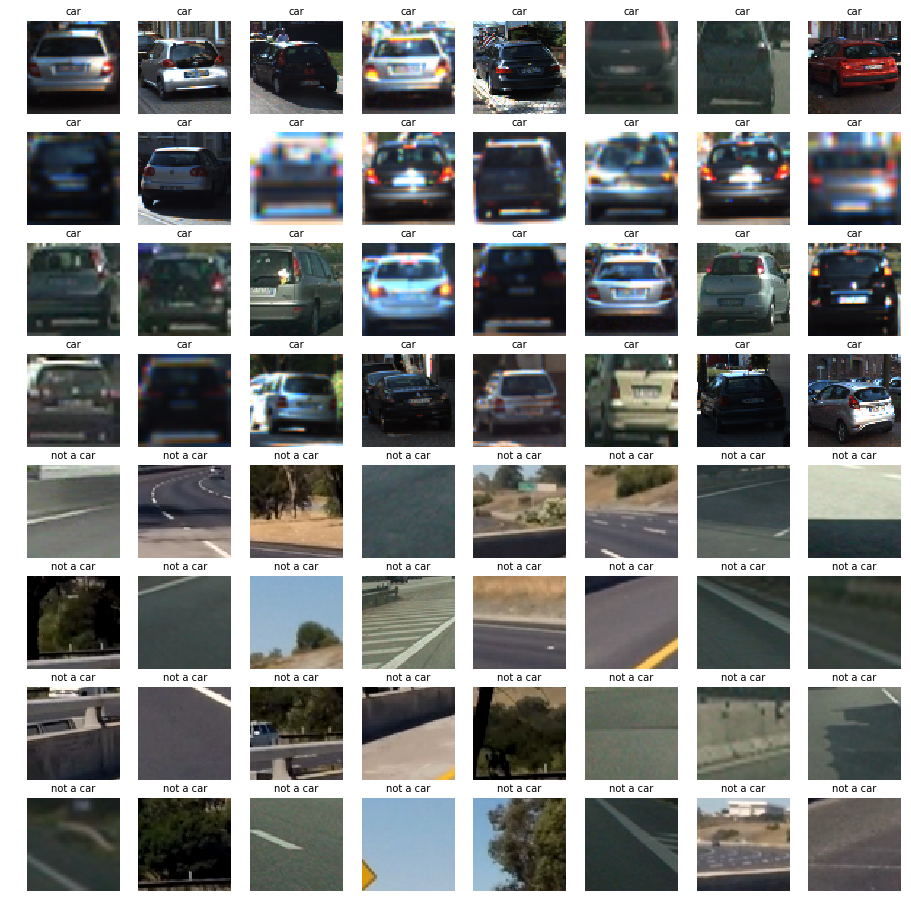

In [2]:
import glob
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt


def display_random_images(img_paths):
    car_images = img_paths[0]
    noncar_images = img_paths[1]
    fig, axs = plt.subplots(8,8, figsize=(16, 16))
    fig.subplots_adjust(hspace = .2, wspace=.001)
    axs = axs.ravel()

    # Step through the list and search for chessboard corners
    for i in np.arange(32):
        img = cv2.imread(car_images[np.random.randint(0,len(car_images))])
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        axs[i].axis('off')
        axs[i].set_title('car', fontsize=10)
        axs[i].imshow(img)
    for i in np.arange(32,64):
        img = cv2.imread(noncar_images[np.random.randint(0,len(noncar_images))])
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        axs[i].axis('off')
        axs[i].set_title('not a car', fontsize=10)
        axs[i].imshow(img)

def grab_video_sample(path_to_file= "", sample_length=10):
    if path_to_file == "":
        raise TypeError('empty path')
    pass

#make sure everything is in RGB colorspace from the start
def read_image(path):
    img= cv2.imread(path)
    return cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

car_images = glob.glob('sample_data/vehicles/**/*.png')
noncar_images = glob.glob('sample_data/non-vehicles/**/*.png')
print(len(car_images), len(noncar_images))
display_random_images([car_images,noncar_images])

__Extract features__

1. First make sure all the feature extraction function are working as expected
2. Define a feature extraction function that implements the efficient way for HOG
This function returns a feature vector containing : histograms of colors, spatial color bins and HOG 

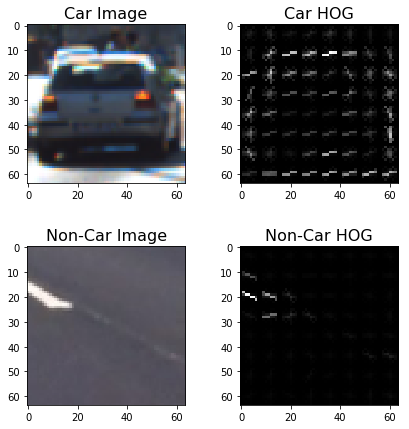

In [3]:
#extract and visualise HOG features 

#NOTE: extract_hog() function was created in a separate file, its imported at the begining of this notebook
random_idx= np.random.randint(np.min([len(car_images),len(noncar_images)]))
car_img = read_image(car_images[random_idx - 1])
_, car_dst = get_hog_features(car_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)
noncar_img = read_image(noncar_images[random_idx])
_, noncar_dst = get_hog_features(noncar_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)

# Visualize 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,7))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(car_img)
ax1.set_title('Car Image', fontsize=16)
ax2.imshow(car_dst, cmap='gray')
ax2.set_title('Car HOG', fontsize=16)
ax3.imshow(noncar_img)
ax3.set_title('Non-Car Image', fontsize=16)
ax4.imshow(noncar_dst, cmap='gray')
ax4.set_title('Non-Car HOG', fontsize=16)

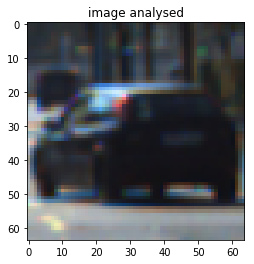

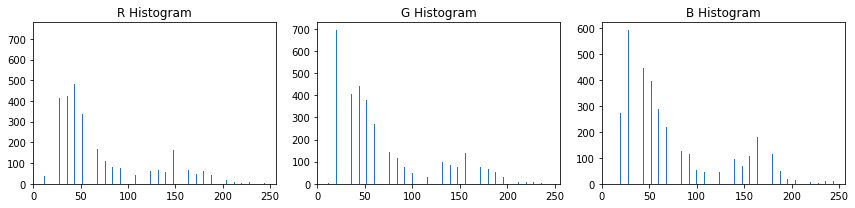

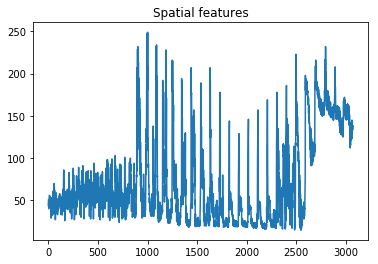

In [4]:
#extract and visualise color features (Spacial bins and color histograms)
random_idx= np.random.randint(np.min([len(car_images),len(noncar_images)]))
car_img = read_image(car_images[random_idx - 1])

#get the features
spatial_features = bin_spatial(car_img, size=(32, 32))
#_,_,_,_,hist_features = color_hist(car_img, nbins=32, bins_range=(0, 256))

#visualize
rh, gh, bh, bincen, feature_vec = color_hist(car_img, nbins=32, bins_range=(0, 256))

plt.figure()
plt.imshow(car_img)
plt.title('image analysed')

# Plot a figure with all three bar charts
if rh is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(132)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(133)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    fig.tight_layout()
    
plt.figure()
plt.plot(spatial_features)
plt.title('Spatial features')

__train a classifier using the samples__

In [5]:
#the following function was copied from the class material but was slightly modified to read images constistently with the
#rest of the code in this project, using the read_image function

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = read_image(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel],
                                        orient, pix_per_cell, cell_per_block,
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [13]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

#create labels, randomize (shuffle) and normalize the data 
def get_training_and_test_data(car_images, noncar_images):
    
    #extract features from car images and create y labels
    car_features = extract_features(car_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    
    notcar_features = extract_features(noncar_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    
    
    #X = np.vstack((car_features, notcar_features)).astype(np.float64)
    #y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
        
    # Split up data into randomized training and test sets
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random.randint(0, 100))
    
    #X_train, X_test, y_train, y_test,
    return  car_features, notcar_features

In [10]:
#all the parameters are defined here
### TODO: Tweak these parameters and see how the results change.
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
#xy_window= (92, 92) #size (width, height) of the sliding windows
y_start_stop = [400, None] # Min and max in y to search in slide_window()

In [14]:
from sklearn.preprocessing import StandardScaler
#X_train, X_test, y_train, y_test = get_training_and_test_data(car_images, noncar_images)
car_features, notcar_features = get_training_and_test_data(car_images, noncar_images)
#X_scaler = StandardScaler().fit(X_train)
#clf = LinearSVC()
#svc.fit(X_train, y_train)

NameError: name 'X_train' is not defined

__make a function that takes a video frame and returns a list of raw bounding boxes with positive detections using the classifier__

In [ ]:
def detect_vehicles(frame, clf):
    bboxes= []
    pass

In [15]:
car_features

[array([44, 125, 132, ..., 0.0010240983061653738, 0.0, 0.0], dtype=object),
 array([151, 171, 65, ..., 0.04036980180222658, 0.02541099979942619,
        0.014010775968593516], dtype=object),
 array([157, 117, 121, ..., 0.024836645466406248, 0.06430390828756641,
        0.06484292238965436], dtype=object),
 array([40, 138, 115, ..., 0.23837200309556744, 0.2233826987358757,
        0.12154560580430397], dtype=object),
 array([14, 128, 130, ..., 0.0, 0.002955364804289831, 0.001150834833866955],
       dtype=object),
 array([21, 128, 131, ..., 0.012983608585623918, 0.0278467904030078,
        0.010503420024715271], dtype=object),
 array([163, 116, 141, ..., 0.056963390136203176, 0.014570077956258112,
        0.013279447529547803], dtype=object),
 array([181, 115, 146, ..., 0.0, 0.0, 0.0], dtype=object),
 array([29, 129, 128, ..., 0.0, 0.13827646371986982, 0.7422441740590484],
       dtype=object),
 array([31, 128, 131, ..., 0.0012698676531807528, 0.00019909057118267857,
        0.0], dtype